In [481]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [482]:
file = open('./.env')
api = file.read()

In [483]:
def search_igdb(n): 
  
    #set up an empty list to append each API call
    output = []
    url = 'https://api-v3.igdb.com/games/?limit=50'
    #establish URL and api_key
    headers = {
    'user-key': api,
    'accept': 'application/json'
     }
    #loops through a list of n length and updates offset after each call
    for i in list(range(n)): 
        offset = 0
        offset += 50*i 
        url_params = {
            'fields':'name, total_rating_count, total_rating, rating_count, rating, popularity, aggregated_rating, aggregated_rating_count, themes, platforms, first_release_date, player_perspectives, hypes, game_modes, game_engines, genres', 
            #'filter[release_dates.platform][any]': '48,49,6',
            'filter[total_rating_count][gte]': '150',
            'filter[rating_count][gte]': '100',
            'filter[aggregated_rating_count][gte]': '10',
            'offset': offset
      
      
      
    #         'filter'= filter[release_dates.platform][any] = 48,49,6
    #         'filter'= filter[total_rating_count][gte] = 1
          }
        #fields=*&filter[release_dates.platform][any]=48,49,6
    
    
        response = requests.get(url, headers=headers, params=url_params)
        #run our request get requests
    
  
    
        list(filter(lambda x: output.append(x), response.json()))
     #and 
  
    return output

In [484]:
video_games = search_igdb(4)
df = pd.DataFrame(video_games)

In [485]:
# sort the games by the highest rating 
df = df.sort_values('total_rating', ascending=False)

In [486]:
# change the index of the DataFrame to the name of the game
df = df.set_index('name')

In [487]:
# drop the column with the game 'IDs'
df = df.drop(['id'], axis=1)

In [488]:
# changing column names
df = df.rename(columns={'aggregated_rating':'critic_review_rating'})
df = df.rename(columns={'aggregated_rating_count':'critic_review_count'})
df = df.rename(columns={'first_release_date':'release_date'})
df = df.rename(columns={'rating':'player_review_rating'})
df = df.rename(columns={'rating_count':'player_review_rating_count'})
df = df.rename(columns={'total_rating':'total_review_rating'})
df = df.rename(columns={'total_rating_count':'total_review_rating_count'})

In [489]:
# replace the values in our two rows with 
for row in df.loc[df.themes.isnull(), 'themes'].index: 
    df.at[row, 'themes'] = [] 
        
for row in df.loc[df.player_perspectives.isnull(), 'player_perspectives'].index: 
    df.at[row, 'player_perspectives'] = [] 

In [490]:
df = df.fillna(' ')

In [491]:
# getting codes for each column 

platforms_codes = list(df['platforms'])
game_engines_codes = list(df['game_engines'])
player_perspectives_codes = list(df['player_perspectives'])
game_modes_codes = list(df['game_modes'])
themes_codes = list(df['themes'])

def unique_column_set(column):
    unique_letters = [] 
    for letters in column:
        for letter in letters:
            if letters != '':
                unique_letters.append(letter)
    return set(unique_letters)

unique_platforms_codes = unique_column_set(platforms_codes)
unique_game_engines_codes = unique_column_set(game_engines_codes)
unique_player_perspectives_codes = unique_column_set(player_perspectives_codes)
unique_game_modes_codes = unique_column_set(game_modes_codes)
unique_themes_codes = unique_column_set(themes_codes)

In [492]:
# getting all the values for release_dates in a unique set

unix_codes = list(df['release_date'])

def unique_release_set(lst):
    unique_dates = [] 
    for date in lst:
                unique_dates.append(date)
    return set(unique_dates)

unique_release_codes = unique_release_set(unix_codes)

In [493]:
# converting epoch to human readable date
df['release_date'] = pd.to_datetime(df['release_date'], unit='s')

In [494]:
# creating a new column called year which displays just the year the game released in standart date time
df['release_year'] = df['release_date'].dt.year

In [495]:
# round off the digits by 2 decimal places
df['critic_review_rating']= round(df['critic_review_rating'], 2)
df['popularity']= round(df['popularity'], 2)
df['player_review_rating']= round(df['player_review_rating'], 2)
df['player_review_rating_count']= round(df['player_review_rating_count'], 2)
df['total_review_rating']= round(df['total_review_rating'], 2)

In [496]:
# created dictionary with keys as game_mode and values as the corresponding ID
game_modes = {'Single Player':1, 
              'Multiplayer':2 , 
              'Co-operative':3, 
              'Split Screen':4, 
              'Massively Multiplayer Online':5}  

In [497]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)

In [498]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)

In [499]:
#created dictionary with keys as platform and values as corresponding ID for each platform
platforms = {'Linux': 3,
'Wii': 5 ,
'PC': 6,
'PS3': 9,
'Xbox': 11,
'Xbox 360':12,
'Mac': 14,
'Nintendo DS':20,
'Android':34,
'Xbox Live Arcade':36,
'Nintendo 3DS': 37,
'iOS':39,
'Wii U':41,
'PlayStation Network':45,
'PlayStation Vita':46,
'PS4':48,
'Xbox One':49,
'Arcade':52,
'Ouya':72,
'Windows Phone':74,
'SteamOS':92,
'Nintendo Switch':130,
'Nintendo DSi':159}

In [500]:
#goes through each list in the platform column and creates a dummy variable for each platform type and adds a boolean expression if the game in question is offered on that platform
for platform in platforms.keys():
    df[platform] = df.platforms.apply(lambda plat_list: platforms[platform] in plat_list) 

In [501]:
themes = {'Action':1,
    'Fantasy': 17,
    'Science-Fiction': 18,
    'Horror': 19,
    'Thriller': 20,
    'Survival': 21,
    'Historical': 22,
    'Stealth': 23,
    'Comedy': 27,
    'Business': 28,
    'Drama': 31,
    'Non-Fiction': 32,
    'Sandbox': 33,
    'Educational': 34,
    'Kids': 35,
    'Open-world': 38,
    'Warfare': 39,
    'Erotic': 42,
    'Mystery': 43 }

In [502]:
#perform the repeated for loop on the them column and then drop the theme column
for theme in themes.keys():
    df[theme] = df.themes.apply(lambda theme_list: themes[theme] in theme_list)

In [503]:
#repeat for player_perspectives
player_perspectives = {'First-Person':1,
    'Third-Person': 2,
    'Bird-view': 3,
    'Side-view': 4,
    'Text': 5,
    'Aural': 6,
    'Virtual Reality': 7}

In [504]:
for player_perspective in player_perspectives.keys():
    df[player_perspective] = df.player_perspectives.apply(lambda pp_list: player_perspectives[player_perspective] in pp_list)

In [505]:
#repeating the process for genres defining our dictionary
genres = {'Simulator':13,
'Tactical':24,
'Quiz/Trivia':26,
'Fighting':4,
'Strategy':15,
'Adventure':31,
'Role-playing (RPG)':12,
'Shooter':5,
'Music':7,
'Indie':32,
'Turn-based strategy (TBS)':16,
'Pinball':30,
'Puzzle':9,
'Real Time Strategy (RTS)':11,
'Hack and slash/Beat ’em up':25,
'Platform':8,
'Racing':10,
'Sport':14,
'Arcade':33,
'Point-and-click':2}

In [506]:
for genre in genres.keys():
    df[genre] = df.genres.apply(lambda genre_list: genres[genre] in genre_list)

In [507]:
df = df.drop(['platforms'], axis=1) 

In [508]:
df = df.drop(['genres'], axis=1) 

In [509]:
df = df.drop(['game_modes'], axis=1)

In [510]:
df = df.drop(['player_perspectives'], axis=1)

In [511]:
df = df.drop(['themes'], axis=1)

In [512]:
df.head()

,critic_review_rating,critic_review_count,release_date,game_engines,hypes,popularity,player_review_rating,player_review_rating_count,total_review_rating,total_review_rating_count,...,Indie,Turn-based strategy (TBS),Pinball,Puzzle,Real Time Strategy (RTS),Hack and slash/Beat ’em up,Platform,Racing,Sport,Point-and-click
name,,,,,,,,,,,,,,,,,,,,,
Red Dead Redemption 2,95.92,22,2018-10-26,[26],257,224.52,97.46,205,96.69,227,...,False,False,False,False,False,False,False,False,False,False
God of War,96.94,21,2018-04-20,,92,117.30,96.30,377,96.62,398,...,False,False,False,False,False,False,False,False,False,False
The Last of Us Remastered,97.40,11,2014-07-29,,5,23.35,93.22,465,95.31,476,...,False,False,False,False,False,False,False,False,False,False
The Legend of Zelda: Breath of the Wild,97.59,31,2017-03-03,"[17, 502, 503]",142,67.09,92.58,469,95.09,500,...,False,False,False,False,False,False,False,False,False,False
Super Mario Odyssey,96.71,19,2017-10-27,,88,37.61,91.95,279,94.33,298,...,False,False,False,False,False,False,True,False,False,False


# Did video games get better or worse overtime?

In [513]:
# mean values for all columns by release_year
release_year_mean = df.groupby(['release_year']).mean()

Text(0.5, 1.0, 'Average rating of the top game by year')

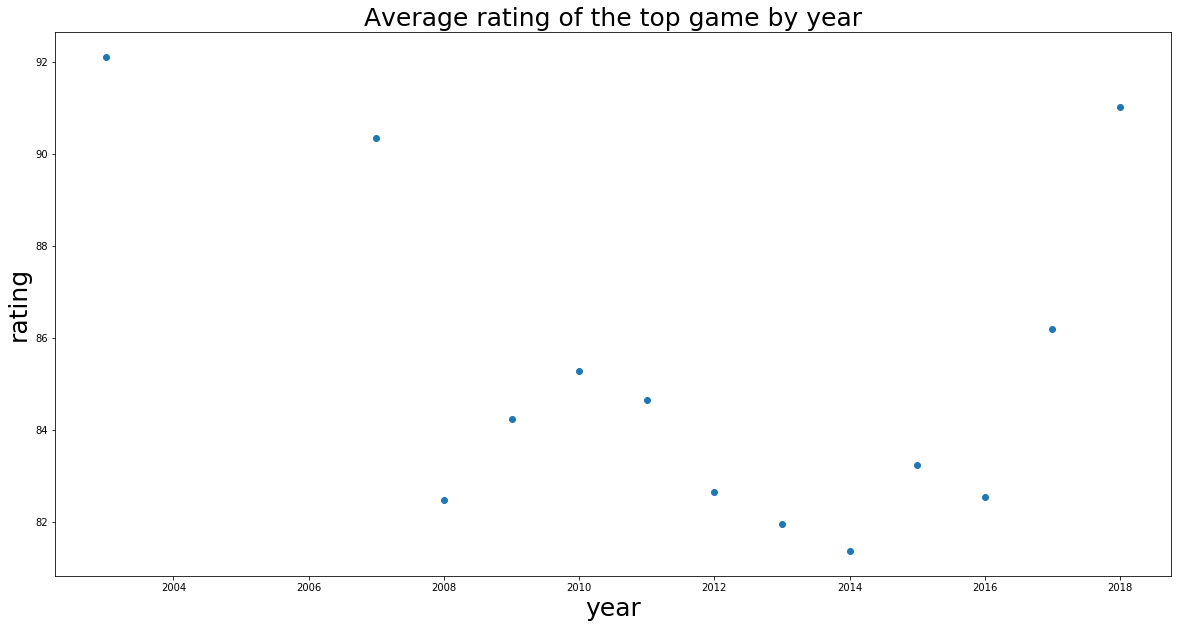

In [514]:
new_figure = plt.figure(figsize=(20,10))
ax = new_figure.add_subplot(111)
ax.scatter(release_year_mean.index , release_year_mean.total_review_rating)
ax.set_xlabel('year', size=25)
ax.set_ylabel('rating', size=25)
ax.set_title('Average rating of the top game by year', size=25)

In [553]:
xbox = df[(df["Xbox One"] == True) | (df["Xbox"] == True) | (df["Xbox 360"] == True) | (df["Xbox Live Arcade"] == True)].mean()

In [554]:
ps = df[(df["PlayStation Vita"] == True) | (df["PS3"] == True) | (df["PS4"] == True) | (df["PlayStation Network"] == True)].mean()

In [555]:
nintendo = df[(df["Nintendo DS"] == True) | (df["Wii"] == True) | (df["Wii U"] == True) | (df["Nintendo 3DS"] == True) | (df["Nintendo DSi"] == True) | (df["Nintendo Switch"] == True)].mean()

In [560]:
ps

critic_review_rating              84.159641
critic_review_count               19.748503
popularity                        24.058503
player_review_rating              82.066647
player_review_rating_count       359.544910
total_review_rating               83.113413
total_review_rating_count        379.293413
release_year                    2013.209581
Single Player                      0.994012
Multiplayer                        0.467066
Co-operative                       0.299401
Split Screen                       0.053892
Massively Multiplayer Online       0.023952
Linux                              0.149701
Wii                                0.017964
PC                                 0.874251
PS3                                0.628743
Xbox                               0.000000
Xbox 360                           0.526946
Mac                                0.281437
Nintendo DS                        0.017964
Android                            0.083832
Xbox Live Arcade                

In [556]:
df.columns

Index(['critic_review_rating', 'critic_review_count', 'release_date',
       'game_engines', 'hypes', 'popularity', 'player_review_rating',
       'player_review_rating_count', 'total_review_rating',
       'total_review_rating_count', 'release_year', 'Single Player',
       'Multiplayer', 'Co-operative', 'Split Screen',
       'Massively Multiplayer Online', 'Linux', 'Wii', 'PC', 'PS3', 'Xbox',
       'Xbox 360', 'Mac', 'Nintendo DS', 'Android', 'Xbox Live Arcade',
       'Nintendo 3DS', 'iOS', 'Wii U', 'PlayStation Network',
       'PlayStation Vita', 'PS4', 'Xbox One', 'Arcade', 'Ouya',
       'Windows Phone', 'SteamOS', 'Nintendo Switch', 'Nintendo DSi', 'Action',
       'Fantasy', 'Science-Fiction', 'Horror', 'Thriller', 'Survival',
       'Historical', 'Stealth', 'Comedy', 'Business', 'Drama', 'Non-Fiction',
       'Sandbox', 'Educational', 'Kids', 'Open-world', 'Warfare', 'Erotic',
       'Mystery', 'First-Person', 'Third-Person', 'Bird-view', 'Side-view',
       'Text', 'Aural'

In [563]:
x_ps = [ps['Simulator'], ps['Tactical'],
       ps['Quiz/Trivia'], ps['Fighting'], ps['Strategy'], ps['Adventure'],
       ps['Role-playing (RPG)'], ps['Shooter'], ps['Music'], ps['Indie'],
      ps['Turn-based strategy (TBS)'], ps['Pinball'], ps['Puzzle'],
       ps['Real Time Strategy (RTS)'], ps['Hack and slash/Beat ’em up'], ps['Platform'],
       ps['Racing'], ps['Sport'], ps['Point-and-click']]

In [564]:
y_ps = [['Simulator'], ['Tactical'],
       ['Quiz/Trivia'], ['Fighting'], ['Strategy'], ['Adventure'],
       ['Role-playing (RPG)'], ['Shooter'], ['Music'], ['Indie'],
      ['Turn-based strategy (TBS)'], ['Pinball'], ['Puzzle'],
       ['Real Time Strategy (RTS)'], ['Hack and slash/Beat ’em up'], ['Platform'],
       ['Racing'], ['Sport'], ['Point-and-click']]

In [565]:
xb_genres = [ps['Simulator'], ['Tactical'],
       ['Quiz/Trivia'], ['Fighting'], ['Strategy'], ['Adventure'],
       ['Role-playing (RPG)'], ['Shooter'], ['Music'], ['Indie'],
      ['Turn-based strategy (TBS)'], ['Pinball'], ['Puzzle'],
       ['Real Time Strategy (RTS)'], ['Hack and slash/Beat ’em up'], ['Platform'],
       ['Racing'], ['Sport'], ['Point-and-click']

SyntaxError: unexpected EOF while parsing (<ipython-input-565-c916664730e3>, line 6)

In [566]:
nintendo_genres = [ps['Simulator'], ['Tactical'],
       ['Quiz/Trivia'], ['Fighting'], ['Strategy'], ['Adventure'],
       ['Role-playing (RPG)'], ['Shooter'], ['Music'], ['Indie'],
      ['Turn-based strategy (TBS)'], ['Pinball'], ['Puzzle'],
       ['Real Time Strategy (RTS)'], ['Hack and slash/Beat ’em up'], ['Platform'],
       ['Racing'], ['Sport'], ['Point-and-click']

SyntaxError: unexpected EOF while parsing (<ipython-input-566-f2c0d57d4341>, line 6)

TypeError: only size-1 arrays can be converted to Python scalars

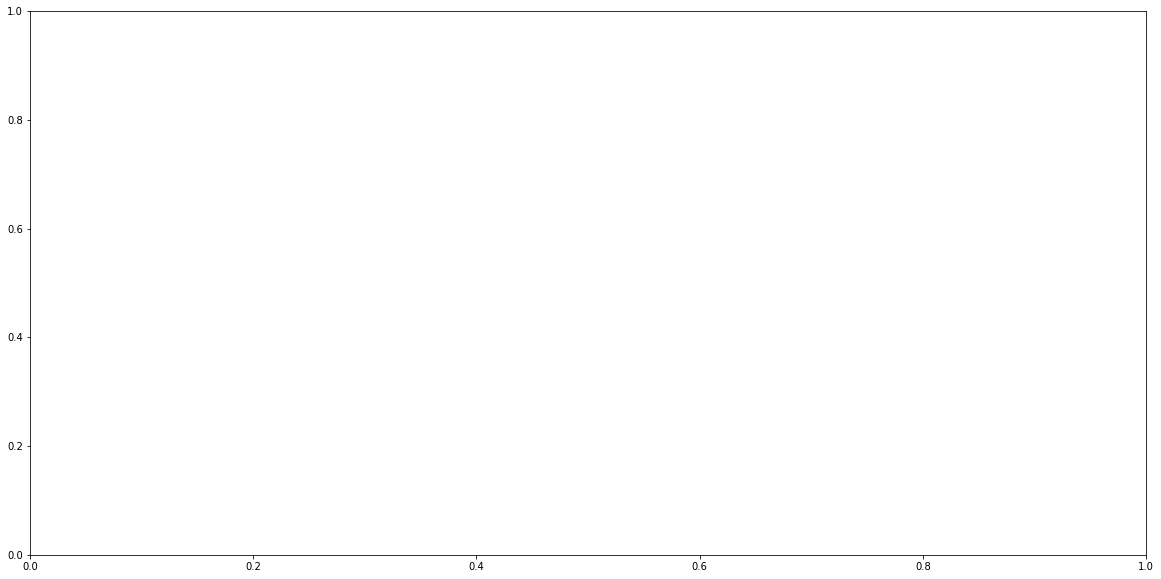

In [567]:
new_figure = plt.figure(figsize=(20,10))
ax = new_figure.add_subplot(111)
ax.bar(x_ps, y_ps)
ax.set_xlabel('year', size=25)
ax.set_ylabel('rating', size=25)
ax.set_title('Average rating of the top game by year', size=25)